<a href="https://colab.research.google.com/github/Manu-Sanchez/Learning/blob/ai%2Fbasic-gan/Advanced_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=2e6a4298971cdbb90678afb26a781e9708d7c02b503d495a3c63c2ea2e6595dc
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
import os
import pdb
import PIL

from PIL import Image

import torch
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchviz import make_dot
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib inline

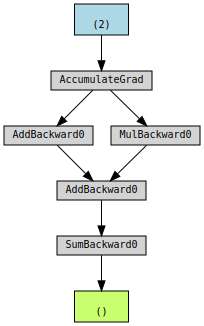

In [4]:
x = torch.ones(2, requires_grad = True)
y = x + 1
z = x * 1
w = (y + z).sum()
make_dot(w)


In [5]:
def show(tensor, num=12, wamb=0, name=''):
  data = tensor.detach()

  if tensor.is_cuda:
    data = data.cpu()

  grid = make_grid(data[:num], nrows=int(math.sqrt(num))).permute(1,2,0)

  plt.imshow(grid.clip(0,1)) #Clip the pixel values between 0 and 1
  plt.show()

In [6]:
epochs = 1e4
batch_size = 128
lr = 1e-4
z_dim = 200 #Latent space size

cur_step = 0
crit_cycles = 5 #5 Cycles of the critic and 1 of the generator

gen_loss = []
crit_loss = []
show_step = 35
save_step = 35

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



In [7]:
class Generator(nn.Module):

  def __init__(self, z_dim = 200, d_dim = 16):
    """
    Geneator Module

    z_dim: Refers to the input channels
    d_dim: Refers to the output image size
    """
    super().__init__()

    self.gen_model = nn.Sequential(
        # ConvTranspose2d Reduces the ammount of channels to increase image size, new image size will be determined by the formula (n-1) * stride - 2 * padding + ks
        # n = width or height
        # ks = kernel size

        # Actual input image it will only be one pixel but it will be expressed in the number of channels (200)
        nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), # New Shape (1 - 1) * 1 - 2 * 0 + 4 = 0 * 1 + 4 = 4x4, channels 200 -> 16 * 32 = 512
        nn.BatchNorm2d(d_dim * 32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 32, d_dim * 16, 4, 2, 1), # New Shape (4 - 1) * 2 - 2 * 1 + 4 = 3 * 2 - 2 + 4 = 6 + 2 = 8x8, channels 16 * 32 = 512 -> 16 * 16 = 256
        nn.BatchNorm2d(d_dim * 16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 16, d_dim * 8, 4, 2, 1), # New Shape (8 - 1) * 2 - 2 * 1 + 4 = 7 * 2 - 2 + 4 = 14 + 2 = 16x16, channels 16 * 16 = 256 -> 16 * 8 = 128
        nn.BatchNorm2d(d_dim * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 8, d_dim * 4, 4, 2, 1), # New Shape (16 - 1) * 2 - 2 * 1 + 4 = 15 * 2 - 2 + 4 = 30 + 2 = 32x32, channels 16 * 8 = 128 -> 16 * 4 = 64
        nn.BatchNorm2d(d_dim * 4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 4, d_dim * 2, 4, 2, 1), # New Shape (32 - 1) * 2 - 2 * 1 + 4 = 31 * 2 - 2 + 4 = 62 + 2 = 64x64, channels 16 * 4 = 64 -> 16 * 2 = 32
        nn.BatchNorm2d(d_dim * 2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 2, 3, 4, 2, 1), # New Shape (64 - 1) * 2 - 2 * 1 + 4 = 63 * 2 - 2 + 4 = 126 + 2 = 128x128, channels 16 * 4 = 256 -> 3 (rgb)
        nn.Tanh() #Outputs a value between [-1, 1]
    )

  def forward(self, noise):
    #Noise is batch of pixels len(noise) == size of the batch
    x = noise.reshape(len(noise), self.z_dim, 1, 1) # Batch Size: 128 x Num Channels: 200 x Pixel Size: (1 x 1)

    self.gen_model(noise)

In [8]:
def gen_noise(num, z_dim, device):
  return torch.randn(num, z_dim, device=device) #128x200

In [10]:
class Critic(nn.Module):

  def __init__(self):
    super().__init__()

    self.critic_model = nn.Sequential(
        # Conv2d Reduces the image size to increase number of channels, new image size will be determined by the formula (n+2 * padding - ks)//stride + 1
        # n = width or height
        # ks = kernel size
        nn.Conv2d(3, 16, 4, 2, 1), #New Shape (128 + 2 * 1 - 4)//2 + 1 = (128 + 2 - 4)//2 + 1 = 126//2 + 1 = 63 + 1 = 64x64, channels 3 -> 16
        nn.InstanceNorm2d(16),
        nn.LeakyReLU(.2),

        nn.Conv2d(16, 32, 4, 2, 1), #New Shape (64 + 2 * 1 - 4)//2 + 1 = (64 + 2 - 4)//2 + 1 = 62//2 + 1 = 31 + 1 = 32x32, channels 16 -> 32
        nn.InstanceNorm2d(32),
        nn.LeakyReLU(.2),

        nn.Conv2d(32, 64, 4, 2, 1), #New Shape (32 + 2 * 1 - 4)//2 + 1 = (32 + 2 - 4)//2 + 1 = 30//2 + 1 = 15 + 1 = 16x16, channels 32 -> 64
        nn.InstanceNorm2d(64),
        nn.LeakyReLU(.2),

        nn.Conv2d(64, 128, 4, 2, 1), #New Shape (16 + 2 * 1 - 4)//2 + 1 = (16 + 2 - 4)//2 + 1 = 14//2 + 1 = 7 + 1 = 8x8, channels 64 -> 128
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(.2),

        nn.Conv2d(128, 256, 4, 2, 1), #New Shape (8 + 2 * 1 - 4)//2 + 1 = (8 + 2 - 4)//2 + 1 = 6//2 + 1 = 3 + 1 = 4x4, channels 128 -> 256
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(.2),

        nn.Conv2d(256, 1, 4, 1, 0) #New Shape (4 + 2 * 1 - 4)//1 + 0 = (4 + 2 - 4)//1 + 0 = 2//2 + 0 = 1 + 0 = 1x1, channels 256 -> 1
    )

  def forward(self, image):
    #Image: Batch Size: 128 x Num Channels: 3 x Image Size: (128 x 128)
    crit_pred = self.critic_model(image)

    return crit_pred.reahspe(len(crit_pred), -1) #128, 1

In [ ]:
#Optional
def init_weights(m):
  """
  How to initialize the model weights or biases (in case we want to set our own values)
  """
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weights, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weights, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

#  generator = Generator().apply(init_weights)
# critic = Critic().apply(init_weights)

In [14]:
#DATA LOAD
import gdown, zipfile

url='https://dl.dropboxusercontent.com/scl/fi/vltmt8hlgdf9mv9kn7d0b/img_align_celeba.zip?rlkey=tacwpkr8d9bjpctdftjg3b00a'
path = 'data/celeba'
download_path = f"{path}/img_align_celeba.zip"
if not os.path.exists(path): os.makedirs(path)
gdown.download(url, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as dataset:
    dataset.extractall(path)

Downloading...
From: https://dl.dropboxusercontent.com/scl/fi/vltmt8hlgdf9mv9kn7d0b/img_align_celeba.zip?rlkey=tacwpkr8d9bjpctdftjg3b00a
To: /content/data/celeba/img_align_celeba.zip
 73%|███████▎  | 1.06G/1.44G [00:45<00:15, 24.6MB/s]

KeyboardInterrupt: 